## Dependencias

In [1]:
import numpy as np
import pandas as pd

import datetime

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.svm import SVC

from functools import reduce

import seaborn as sns
import cufflinks as cf

cf.go_offline()

## Lectura de datos

In [2]:
ruta = '/home/oscarjarillo/Documentos/Análisis Multivariado/Perceptron/Fraud.csv'

In [3]:
df = pd.read_csv(ruta)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

## Definición de variables

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
vart = ['isFraud']
var = [v for v in df.columns if df[v].dtype != 'object' and v not in vart and v != 'isFlaggedFraud' ]

## Análisis exploratorio

### Balanceo de muestra 

In [7]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [8]:
Xi = pd.concat([d.sample(8213).reset_index(drop=True).assign(isFraud = t) for t,d in df.groupby('isFraud')], ignore_index=True)

In [9]:
Xi.shape

(16426, 11)

### Valores nulos

In [10]:
fuera = 1 - Xi[var + vart].describe(percentiles=[0.01,0.99]).T[['count']]/len(Xi)
fuera

,count
step,0.0
amount,0.0
oldbalanceOrg,0.0
newbalanceOrig,0.0
oldbalanceDest,0.0
newbalanceDest,0.0
isFraud,0.0


### Varianza nula

In [11]:
vt = VarianceThreshold()
vt.fit(Xi[var])

VarianceThreshold()

In [12]:
fuera = [a for a,b in zip(var, vt.get_support()) if not b]
fuera

[]

### Selección de variables con mejor poder predictivo

In [13]:
sk = SelectKBest(k = 2)
sk.fit(Xi[var], Xi[vart[0]])

SelectKBest(k=2)

In [14]:
fuera = [a for a,b in zip(var, sk.get_support()) if not b]
var = [v for v in var if v not in fuera]
Xi.drop(fuera, axis = 1, inplace= True)

In [15]:
aux = pd.DataFrame(zip(var, sk.scores_),columns=['var', 'scores']).set_index('var').sort_values(by = 'scores',
                                                                    ascending= False)
aux = aux[aux.index.isin(var)]
aux.iplot(kind = 'bar',color = 'orange')

### Extremos

array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>]], dtype=object)

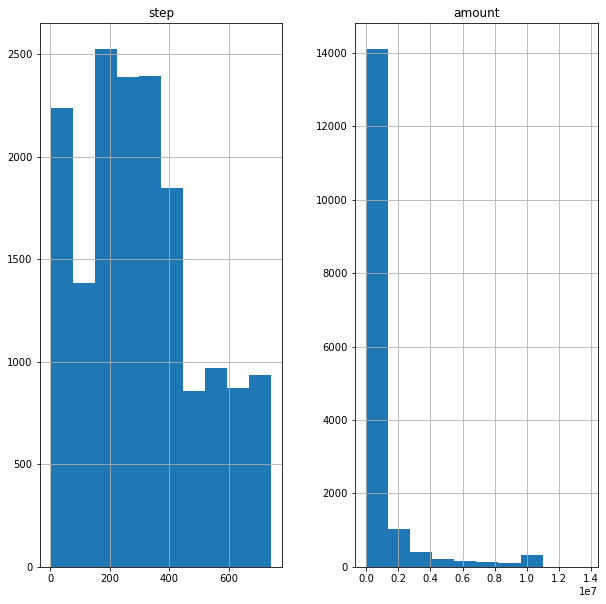

In [16]:
Xi[var].hist(figsize = (10,10))

In [17]:
for v,li,ls in Xi[var].describe(percentiles = [0.01,0.99]).T[['1%', '99%']].reset_index().values:
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex_'] = Xi.filter(like = 'ex_').max(axis = 1)

In [18]:
Xi['ex_'].value_counts(1)

0    0.972909
1    0.027091
Name: ex_, dtype: float64

In [19]:
Xi = Xi.loc[Xi['ex_'] == 0].reset_index(drop=True).drop(Xi.filter(like = 'ex_').columns, axis = 1)

In [20]:
Xi[var + vart].head()

,step,amount,isFraud
0,325,469629.18,0
1,156,239433.28,0
2,155,22081.98,0
3,178,21281.95,0
4,406,112815.65,0


array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>]], dtype=object)

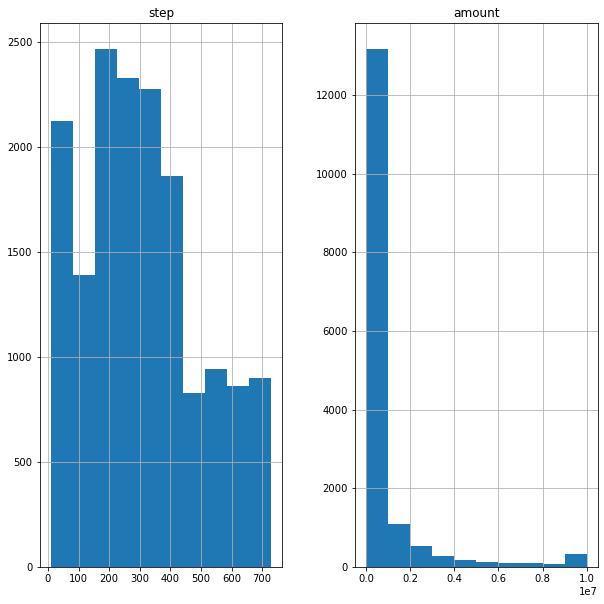

In [21]:
Xi[var].hist(figsize = (10,10))

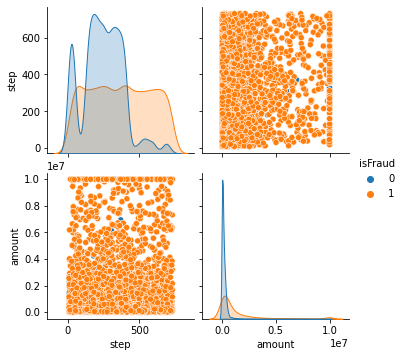

In [22]:
sns.pairplot(data= Xi[var + vart], hue= vart[0])

## Cambio de espacio $\mathcal{X}_{[0,1]}$

In [23]:
sc = MinMaxScaler()
sc.fit(Xi[var])

MinMaxScaler()

In [24]:
X01 = pd.DataFrame(sc.transform(Xi[var]), columns= var)
X01[vart] = Xi[vart]

## Partición

In [25]:
Xt,Xv,yt,yv = train_test_split(X01[var], X01[vart[0]], train_size=0.7)
Xt.reset_index(drop=True, inplace=True)
Xv.reset_index(drop=True, inplace=True)
yt.reset_index(drop=True, inplace=True)
yv.reset_index(drop=True, inplace=True)

## Aprendizaje

### Hiperparametrización

In [26]:
hp = dict(C = np.arange(0.1,2,0.1),
         kernel = ['linear', 'poly', 'rbf', 'sigmoid'],
         degree = range(2,3),
         probability = [True])

In [27]:
modelo = SVC()

In [28]:
n = reduce(lambda x,y:x*y, [len(y) for x,y in hp.items()])
n

76

In [29]:
grid = RandomizedSearchCV(param_distributions=hp,
                         n_iter= n,
                         cv=2,
                         scoring='accuracy',
                         n_jobs=-1,
                         verbose=True,
                         estimator = modelo)

In [30]:
grid.fit(Xt, yt)

Fitting 2 folds for each of 76 candidates, totalling 152 fits


RandomizedSearchCV(cv=2, estimator=SVC(), n_iter=76, n_jobs=-1,
                   param_distributions={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                                        'degree': range(2, 3),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'probability': [True]},
                   scoring='accuracy', verbose=True)

In [31]:
grid.best_params_

{'probability': True, 'kernel': 'rbf', 'degree': 2, 'C': 1.5000000000000002}

In [32]:
modelo = grid.best_estimator_
modelo

SVC(C=1.5000000000000002, degree=2, probability=True)

### Búsqueda de parámetros

In [33]:
modelo.fit(Xt, yt)

SVC(C=1.5000000000000002, degree=2, probability=True)

## Validación del modelo

In [34]:
print(accuracy_score(y_pred= modelo.predict(Xt), y_true = yt))
print(accuracy_score(y_pred= modelo.predict(Xv), y_true = yv))

0.7878598247809763
0.7887382690302398


In [35]:
print(confusion_matrix(y_pred= modelo.predict(Xt), y_true = yt))
print(confusion_matrix(y_pred= modelo.predict(Xv), y_true = yv))

[[5089  564]
 [1809 3724]]
[[2180  222]
 [ 791 1602]]
